【台北大學碩士班課程】淺度機器學習<br>
【授課老師】汪群超<br>
【學期】1112 <br>
【主要內容】分類器的原理與評比實驗：多元羅吉斯回歸、支援向量機、神經網路<br>
【作者】711133117 陳怡升 <br>
【參考網站】
- [汪群超 Shallow Machine Lesson 8: 淺度機器學習：分類器的原理與評比實驗](https://ntpuccw.blog/sml-lesson-8-%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9a%e5%88%86%e9%a1%9e%e5%99%a8%e7%9a%84%e5%8e%9f%e7%90%86%e8%88%87%e8%a9%95%e6%af%94%e5%af%a6%e9%a9%97/)
- 與 SVM 有關的內容 
    - [SVM: Feature Selection and Kernels](https://towardsdatascience.com/svm-feature-selection-and-kernels-840781cc1a6c)
    - [SVM 支援向量機演算法-原理篇](https://iter01.com/582104.html)
- Cross Validation : [Day 5 / 必備實作知識與工具 / 關於 Training，還有一些基本功（一）](https://ithelp.ithome.com.tw/articles/10240556)
---
<font size=4 color=darkblue>目標</font>

本次作業是想要驗證以下 3 點而進行的實驗

- 有／無標準化之完整資料及主成分資料的準確率與執行時間比較
- 介紹多元羅吉斯回歸、支援向量機、神經網路的參數選擇
- 多元羅吉斯回歸、支援向量機、神經網路的比較

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2, glob, time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [3]:
file = r'C:\Course\1112ShallowMachineLearning\data'

In [2]:
file = r'D:\711133117\1112ShallowMachineLearning\data'

# 資料探索

In [4]:
wine_df = pd.read_excel(file + r'\wine.xlsx')
print(f"資料共有 {wine_df.shape[0]} 筆，{wine_df.shape[1]} 個欄位")
wine_df.head(5)

資料共有 178 筆，14 個欄位


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


設定解釋變數和反應變數

In [5]:
X = wine_df.iloc[:, :-1]
y = wine_df.iloc[:, -1]

# 比較資料設定
## 原始資料（沒有標準化），切分 Train 和 Test

在評比各個學習器之前要先介紹訓練資料以及測試資料的差別。機器學習中，會需要學習資料的規則並且進行預測，若將所有資料全部拿來訓練再進行預測，就有點像考試全部都出考古題，連數字都沒改，此時測試出來的準確度就有失公正。因此通常會將完整資料分為訓練資料（Training Data）與測試資料（Test Data），兩者之間不可以有任何的重疊，利用訓練資料來訓練，測試資料來測試模型的準確度。

在此將訓練及測試資料切分為 8 : 2，後續會使用 CrossValidation 的方式進行參數選擇。

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 原始資料（有標準化）

In [7]:
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

## 主成分資料
由下方圖形可見取 10 個主成分就可以有 95\% 原始資料的解釋能力，因此選擇 5 個主成分。

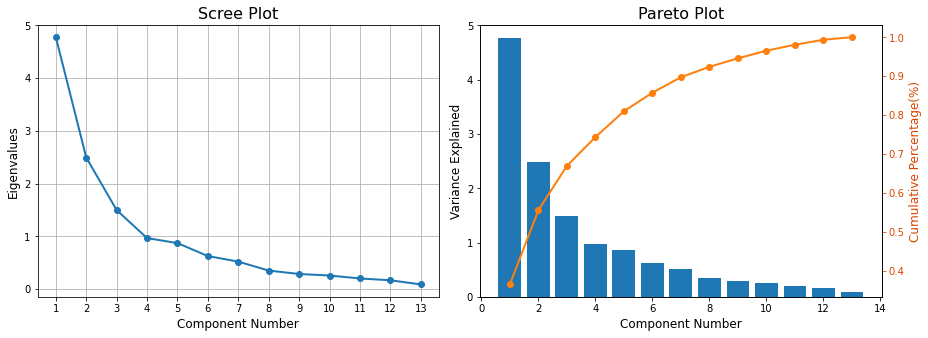

In [8]:
pca = PCA().fit(X_train_)

fig, axes = plt.subplots(ncols=2, figsize=(13,4.8))
x = np.arange(1,1+len(pca.explained_variance_))
axes[0].plot(x, pca.explained_variance_, marker='o', lw=2)
axes[0].set_xticks(x)
axes[0].set_xlabel('Component Number', fontsize=12)
axes[0].set_ylabel('Eigenvalues', fontsize=12)
axes[0].grid(True)
axes[0].set_title('Scree Plot', fontsize=16)

axes[1].bar(x, pca.explained_variance_)
ax2 = axes[1].twinx()
ax2.plot(x, pca.explained_variance_ratio_.cumsum(), marker='o', color='C1', lw=2)
ax2.tick_params(axis='y', colors='#D94600')
ax2.set_ylabel('Cumulative Percentage(%)', fontsize=12, color="#D94600")
axes[1].set_xlabel('Component Number', fontsize=12)
axes[1].set_ylabel('Variance Explained', fontsize=12)
axes[1].set_title('Pareto Plot', fontsize=16)

plt.tight_layout()
plt.show()

In [9]:
ratio = 0.95
print("取 {} 個變數，解釋程度有達到 {} %".format(sum(pca.explained_variance_ratio_.cumsum() < ratio)+1, ratio))
n_comp = sum(pca.explained_variance_ratio_.cumsum() < ratio)+1

取 10 個變數，解釋程度有達到 0.95 %


In [10]:
pca = PCA(n_components = n_comp).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)

# 比較資料之間的運算效率及準確度

以羅吉斯為例，對三種資料進行訓練及預測，紀錄測試資料的準確率及訓練時間，

## 原始資料無標準化

In [11]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = X_train;test = X_test
df_want = pd.DataFrame()

start_time = time.time()
logistic_org = LogisticRegression(solver = 'newton-cg', **opts)
logistic_org.fit(train, y_train)
y_pred = logistic_org.predict(test)
end_time = time.time()
# 紀錄要用的資訊
tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
      'f1score':[f1_score(y_test, y_pred, average='weighted')], 
      'time':[(end_time - start_time)], 'data':['原始資料（無標準化）'],
      'solver':['lbfgs']})
df_want = pd.concat([df_want, tmpdf], ignore_index=True)

## 原始資料有標準化

In [12]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = X_train_;test = X_test_

start_time = time.time()
logistic_org = LogisticRegression(solver = 'newton-cg', **opts)
logistic_org.fit(train, y_train)
y_pred = logistic_org.predict(test)
end_time = time.time()
# 紀錄要用的資訊
tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
      'f1score':[f1_score(y_test, y_pred, average='weighted')], 
      'time':[(end_time - start_time)], 'data':['原始資料（有標準化）'],
      'solver':['lbfgs']})
df_want = pd.concat([df_want, tmpdf], ignore_index=True)

## 主成分資料

In [13]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = Z_train;test = Z_test

start_time = time.time()
logistic_org = LogisticRegression(solver = 'newton-cg', **opts)
logistic_org.fit(train, y_train)
y_pred = logistic_org.predict(test)
end_time = time.time()
# 紀錄要用的資訊
tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
      'f1score':[f1_score(y_test, y_pred, average='weighted')], 
      'time':[(end_time - start_time)], 'data':['10 個主成分資料'],
      'solver':['lbfgs']})
df_want = pd.concat([df_want, tmpdf], ignore_index=True)

## <font color=darkred>比較結果</font>

由下方表格可知，表格中的 time 為執行的時間，是以秒為單位。由於資料量少，因此在運算效率上並沒有太大的差異，只能些微比較出主成分資料有保持原始資料的準確率，後續分類器的參數設定會由主成分資料來進行。

In [14]:
df_want

,Method,accuracy,f1score,time,data,solver
0,Logistic,0.944444,0.944444,0.083403,原始資料（無標準化）,lbfgs
1,Logistic,0.944444,0.944444,0.007969,原始資料（有標準化）,lbfgs
2,Logistic,0.972222,0.972328,0.007673,10 個主成分資料,lbfgs


In [15]:
train = Z_train

# 分類器參數設定

本節會使用到 k 折交叉驗證（k-fold cross-validation），將訓練資料切割成 k 份資料，保留 1 份作為驗證模型的資料，將其餘 k-1 份用來訓練模型，進行 k 次交叉驗證，讓每份資料都有機會驗證一次，其運作方式如下圖所示。

![image.png](https://i.imgur.com/SoH3X9z.png)

【使用程式】

- `StratifiedShuffleSplit` : 切割資料，設定 random_state 固定切割的方式才能比較！

- `GridSearchCV` : 執行所有參數，並找出最佳參數

## 多元羅吉斯迴歸

**<font size=4>參數調整</font>**

多元羅吉斯迴歸在 sklearn 套件中的指令為 `sklearn.linear_model`，指令為 `LogisticRegression`。有不同的演算法可以調整，可以選擇 lbfgs、liblinear、newton-cg、sag、saga，預設為 lbfgs。

- liblinear 適合小的資料集，而 sag 和 saga 適合大型資料，因為運算時間更快

- 針對多類別的反應變數，只有 newton-cg、sag、saga、lbfgs，可以計算 multinomial loss

- liblinear 是 one-versus-rest 的方法

各演算法可以使用的懲罰項：
- lbfgs : l2, None
- liblinear : l1, l2
- newton-cg : l2, None
- sag : l2, None
- saga : elasticnet, l1, l2, None

In [16]:
opts = dict(tol = 0.000001, max_iter = int(1e6))
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg','sag','saga']}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(LogisticRegression(**opts), param_grid=parameters, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)
df_want_logistic = pd.DataFrame(data = grid.cv_results_)

In [17]:
df_want_logistic.loc[:,['param_solver', 'mean_test_accuracy', 'mean_test_f1_macro','mean_fit_time','mean_fit_time']]

,param_solver,mean_test_accuracy,mean_test_f1_macro,mean_fit_time,mean_fit_time
0,lbfgs,0.986207,0.986069,0.004438,0.004438
1,liblinear,0.986207,0.986069,0.000797,0.000797
2,newton-cg,0.986207,0.986069,0.006279,0.006279
3,sag,0.986207,0.986069,0.001601,0.001601
4,saga,0.986207,0.986069,0.007851,0.007851


## 支援向量機（Support Vector Machine，SVM）

SVM是一種用於分類和回歸分析的機器學習算法。在分類問題中，SVM嘗試在找到兩類數據點之間最佳分離超平面（hyperplane），以二維來說超平面就是一條線，以三維來說超平面就是一個面，如下圖所示。
![hyperplane](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*FwrX8viaCLljRAAxiSAp8Q.png)

至於怎麼找出 hyperplane 可以參考 [SVM 支援向量機演算法-原理篇](https://iter01.com/582104.html)。

**<font size=4>參數調整</font>**

SVM 在 sklearn 套件中的指令為 `sklearn.svm`，在此我們使用到之中的 `SVC`，也就是應用在分類問題的 SVM。下方列出 `SVC` 中重要的調整參數及它們的意義。

- `C` : 懲罰係數，就是對誤差的容忍度，預設為 1。

    C 越高，越不能接受誤差，容易過度配適（Overfitting），反之，C越小，接受的誤差太大，就會發生配適不足（Underfitting）的情況。


- `kernel` : 核函式，linear、poly、rbf、sigmoid，預測為 rbf。

    kernel 就是上述文章提到的**核函式**，可以將樣本從低維空間對映到高維空間，讓 SVM 可以處理非線性問題，是 SVM 中的核心角色。其中每個核函式皆會有不同的參數需要調整，SVM 的參數選擇看起來很多，但其實是因為每個核函式要調整參數不同，接著介紹核函式及需要調整的參數。

    - linear : 線性函式
       
    - sigmoid : S 型內核
    
    - poly : 多項函式，會使用到參數 degree、gamma、coef0。

    - rbf : 
        
        
- `degree` : 調整多項式的最高次方，預設為 3，只有在 `kernel='ploy'` 時會用到。


- `gamma` : 單筆資料的影響範圍，scale、auto、非負小數，預設為 scale，只有在核函數是非線性函式會用到，像是：poly、rbf、sigmoid。

    **低代表遠，高則代表近**，因此 gamma 越小，計算 hyperplane 考量到的支援向量就越多，反之。
    
    - scale : $\frac{1}{nfeatures \times X.var()}$
    
    - auto : $\frac{1}{nfeatures}$


- `decision_function_shape` : 決策函數，ovr 或 ovo，預設為 ovr。
    
    - ovr : one-vs-rest，每個群組在建立 hyperplane 時是以其他全部群組作為對立面，可以不用運算那麼多次，但就會是不平衡資料。
    
    - ovo : one-vs-one，每個群組在建立 hyperplane 時是以其他個別群組作為對立面，要運算較多次。

In [18]:
def boxplotset(xcol, ycol, df_want):
    draw_dict = {}
    for i in np.sort(list(set(df_want[xcol]))):
        draw_dict[i] = df_want.loc[df_want[xcol]==i, ycol]
    plt.boxplot([i for i in draw_dict.values()], labels=[str(i) for i in draw_dict.keys()])
    plt.ylabel(ycol)
    plt.xlabel(xcol)
    plt.show()

### 比較決策函數


In [19]:
C_range = [1, 10, 100, 1000]
gamma_range = np.logspace(-4, 1, 6)
parameters = {'decision_function_shape':('ovr','ovo'), 'C':C_range, 'gamma':gamma_range}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(SVC(), param_grid=parameters, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)
df_want = pd.DataFrame(data = grid.cv_results_)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.01} with a score of 0.99


`mean_fit_time` 是配適時間，以秒為單位，紅酒資料中的類別只有 3 類，並沒有太多類別，而且資料筆數少，所以執行時間上並不會有太大的差距。

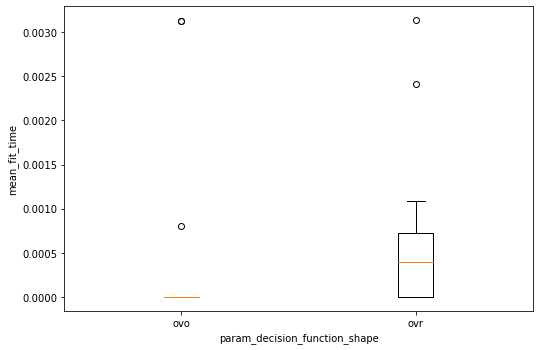

In [20]:
plt.figure(figsize=(8.4,5.6))
boxplotset('param_decision_function_shape', 'mean_fit_time', df_want)

### 比較剩餘參數


In [64]:
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [1, 10]

parameters = [{'kernel': ['linear'], 'C':C_range}, 
              {'kernel': ['rbf', 'sigmoid'], 'gamma':gamma_range, 'C':C_range},
              {'kernel': ['poly'], 'gamma':gamma_range, 'C':C_range, 'degree':[2,3,4,5,6]}]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(SVC(kernel='poly'), param_grid=parameters, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)

df_want = pd.DataFrame(data = grid.cv_results_)
print("The best parameters are %s with an accuracy of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.1, 'kernel': 'linear'} with an accuracy of 0.99


In [68]:
df_want.loc[df_want['mean_test_f1_macro']==df_want['mean_test_f1_macro'].max(),['params', 'mean_test_f1_macro']]

,params,mean_test_f1_macro
1,"{'C': 0.1, 'kernel': 'linear'}",0.986069


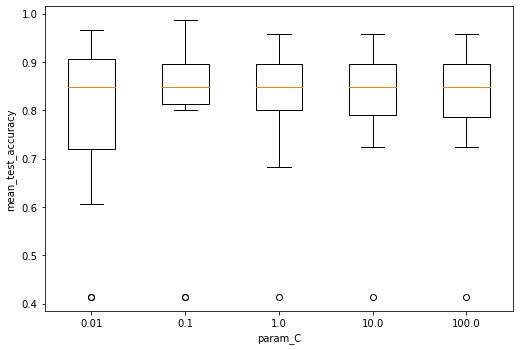

In [70]:
plt.figure(figsize=(8.4,5.6))
boxplotset('param_C', 'mean_test_accuracy',df_want)

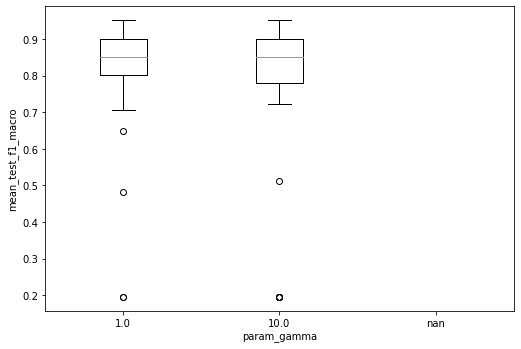

In [71]:
plt.figure(figsize=(8.4,5.6))
boxplotset('param_gamma', 'mean_test_f1_macro',df_want)

In [81]:
print("模型參數：{}".format(grid.best_params_))
opts = grid.best_params_

svm = SVC( **opts)
svm.fit(train, y_train)
y_pred = svm.predict(test) 

print('準確率為 : {} %'.format(np.round(accuracy_score(y_test, y_pred)*100,2)))
print('f1score 為 : {} %'.format(np.round(f1_score(y_test, y_pred, average='weighted')*100,2)))

模型參數：{'C': 0.1, 'kernel': 'linear'}
準確率為 : 94.44 %
f1score 為 : 94.44 %


## 神經網路
- activation : 'identity', 'logistic', 'tanh', 'relu'
- solver : 'lbfgs', 'sgd', 'adam'

In [103]:
train = Z_train; test = Z_test
df_want = pd.DataFrame()
for N in range(5, 21, 5):
    for activation in ['identity', 'logistic', 'tanh', 'relu']:
        opts = dict(hidden_layer_sizes=(N, ), activation=activation, tol=0.000001, max_iter=int(1e6))
        for solver in ['lbfgs', 'sgd', 'adam']:
            start_time = time.time()
            svm = MLPClassifier(solver=solver, **opts)
            svm.fit(train, y_train)
            y_pred = svm.predict(test) 
            end_time = time.time()
            # 紀錄要用的資訊
            tmpdf = pd.DataFrame(data = {'Method':['NN'], 'accuracy':[accuracy_score(y_test, y_pred)], 
              'f1score':[f1_score(y_test, y_pred, average='weighted')], 
              'time':[(end_time - start_time)], 
              'activation':[activation], 'solver':[solver], '神經元個數':[N]})
            df_want = pd.concat([df_want, tmpdf], ignore_index=True)

In [104]:
df_want

,Method,accuracy,f1score,time,activation,solver,神經元個數
0,NN,0.844444,0.844232,0.036929,identity,lbfgs,5
1,NN,0.888889,0.889894,1.978744,identity,sgd,5
2,NN,0.933333,0.933111,1.942773,identity,adam,5
3,NN,0.866667,0.866726,0.031914,logistic,lbfgs,5
4,NN,0.866667,0.868418,4.923831,logistic,sgd,5
5,NN,0.911111,0.912835,2.319828,logistic,adam,5
6,NN,0.911111,0.912835,0.017951,tanh,lbfgs,5
7,NN,0.888889,0.889894,3.929459,tanh,sgd,5
8,NN,0.866667,0.868418,1.700452,tanh,adam,5
9,NN,0.911111,0.909899,0.030917,relu,lbfgs,5


# 不同資料之間與不同分類器的比較

分別將 3 種資料帶入 3 種不同的分類器進行比較。

- 3 種資料：無標準化的原始資料、標準化的原始資料及主成分資料
- 3 種分類器：多元羅吉斯迴歸、支援向量機（SVM）、神經網路（NN）

In [ ]:
for data in ['沒有標準化', '原始資料標準化', 'PCA']:
    if data == '沒有標準化':
        train = X_train; test =X_test
    elif data == '原始資料標準化':
        train = X_train_; test =X_test_
    else :
        

In [ ]:
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)